# WorlClim data : Historical & future precipitations (1970-2100) - GRAPHS
## 4 SSP scenarios and 9 Global Climatic Models
- Data: https://www.worldclim.org/data/index.html
- author: Loïc Duffar https://github.com/loicduffar

This python notebook uses data from the wordclim web site to compute the evolution of future precipitation on a given watershed (average of the pixels inside the polygon). The ouputs are stored in an excel file.


### How to PROCEED ?
The data files must be divided into different sub-folders:
- a folder containing the 12 tif files of historical monthly interannual averages (1 file per month of the year)
- a folder with 4 sub-folders for the various future periods (1921-1940, 1961-1981, 1981-2100). Each folder contains 4 tif files for each model (and each file contains 12 bands for the the different months).

Then run cells in order:
- <a href=#section01>1)</a> Historical interannual monthly mean 1970-2000
- <a href=#section02>2)</a> Future precipitations
- <a href=#section03>3)</a> Multi index by Model, Scenario and Period
- <a href=#section04>4)</a> Concatenate historical and future precipitation in a single dataframe
- <a href=#section05>5)</a> Plot annual evolution of annual precipitation in future, according to all SSP scenarios and all GCM
- <a href=#section06>6)</a> Plot future evolution for each month, according to 4 SSP scenarios and 9 GCMs
- <a href=#section07>7)</a> Store statistics in a dataframe
- <a href=#section08>8)</a> Plot montly projections (all SSP scenarios and GCMs)
- <a href=#section09>9)</a> Store all outputs in an excel file

###  <a name=section01></a>1) Historical interannual monthly mean 1970-2000
Customize the code below with...
- folder path for historical tif files, 
- folder path for output files, 
- path of the polygon file (folder and file name) for the calculation of the mean water depth

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


Process started. Please wait the ending message ... 
Process completed in  0.012135254200000152  minutes


,1,2,3,4,5,6,7,8,9,10,11,12,Annual
1970-2000 Mean,19.2,25.0,42.6,88.8,170.7,114.8,86.1,133.3,149.4,153.3,71.6,29.8,1084.6


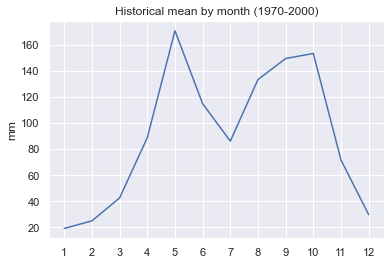

In [2]:
"""
Created on January 2021
@author: Loïc Duffar
"""
import os
import glob2
import rasterstats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# +++++++ Customization
# ....... folder path for the historical tif files (WITHOUT "\" CHARACTER AT THE END !!!)
fld_in = r'D:\Documents\A\Download\Hydro-Climato\WorldClim\Min, max, moy 1970-2000\wc2.1_30s_prec'
# ....... folder path for the output files (WITHOUT "\" CHARACTER AT THE END !!!)
fld_out = r'C:\Users\duffar\Documents\A\ETUDES\2021 Yaque del Sur'
# ....... Polygon file (shape file) for plotting and average computation (path INCLUDING folder)
polygon_file = r'C:\Users\DUFFAR\Documents\A\ETUDES\2021 Yaque del Sur\Carto\Subcuencas_YaqueSur.shp'
historical_period = '1970-2000'

# +++++++ initialisation
annual_label= 'Annual'
baseline_label= historical_period + ' Mean'

# +++++++ Polygon averaged
print('Process started. Please wait the ending message ... ')
start = timeit.default_timer()

results = []
# Loop on raster files (1 file per month)
for raster_file in glob2.glob(os.path.join(fld_in, '*.tif')):
    res = rasterstats.zonal_stats(polygon_file, raster_file, stats=['mean'])
    results.append(round(res[0]['mean'], 1))
stop = timeit.default_timer()
print('Process completed in ', (stop - start)/60, ' minutes')

df = pd.Series(results, index= range(1, 13), name= baseline_label).to_frame().transpose()
sns.set_theme()
df.transpose().plot(xticks= range(1, 13), grid= True,title= "Historical mean by month (1970-2000)", ylabel= "mm", legend= False)
file_historical = 'WorldClim - historical.png'
plt.savefig(os.path.join(fld_out, file_historical), ) # bbox_inches= 'tight' argument optionnel pour limiter la largeur des marges au minimum nécessaire
df[annual_label] = df.sum(axis= 1)
df_historical= df.copy()
display(df_historical)

### <a name=section02></a>2) Future precipitations
Customize the code below with....
- folder path for future tif files (folder containing 4 sub-folders for the 4 future periods)
- Prefix of the file name (begining of the file name, depending on the version of wordclim data, and the resolution of the rasters)
- List of the models e.g. ['BCC-CSM2-MR', 'CNRM-CM6-1', ....] (left-middle of the file name)
- List of the SSP scenarios e.g. ['ssp126', 'ssp245', 'ssp370', 'ssp585'] (right-middle of the file name)
- List of the future periods e.g. ['2021-2040', '2041-2060', '2061-2080', '2081-2100'] (end of the file name)

In [18]:
"""
Created on January 2021
@author: Loïc Duffar
"""
import math
import datetime

# +++++++ Customization
# ....... folder path for the tif files (WITHOUT "\" CHARACTER AT THE END !!!)
fld_in = r'D:\Documents\A\Download\Hydro-Climato\WorldClim\Future data'
# ....... Polygon file (shape file) for plotting and average computation (path INCLUDING folder)
polygon_file = r'C:\Users\DUFFAR\Documents\A\ETUDES\2021 Yaque del Sur\Carto\Subcuencas_YaqueSur.shp'

# ....... Composition of the tif file names
prefix = 'wc2.1_5m_prec'
gcm_list = ['BCC-CSM2-MR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'GFDL-ESM4']
ssp_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
ssp_list_long = ['ssp1-2.6', 'ssp2-4.5', 'ssp3-7.0', 'ssp5-8.5']
period_list = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']

# +++++++ Polygon averaged
print('Process started. Please wait the ending message ... ')
start= datetime.datetime.now()# Start Timer

# +++++++ Process
series = []
for period in period_list:
    path = fld_in + '/' + period
    print('Period --------------', period)
    for gcm in gcm_list:
        for scenario in ssp_list:
            file = os.path.join(path, '_'.join([prefix, gcm, scenario, period]) + '.tif')
            if not os.path.exists(file):
                serie= pd.Series([math.nan for i in range(1, 13)], index= range(1, 13), name= ' '.join([period, scenario, gcm]))
            else:
                results = []
                # Loop over months (1 month by file band)
                for band in range(1, 13):
                    res = rasterstats.zonal_stats(polygon_file, file, stats=['mean'], band= band)
                    results.append(round(res[0]['mean'], 1))
                serie = pd.Series(results, index= range(1, 13), name= ' '.join([period, scenario, gcm]))
            series.append(serie)

df = pd.DataFrame(series)
df[annual_label] = df.sum(axis= 1, skipna= False)

stop = timeit.default_timer()
print("Process completed in ", datetime.datetime.now()-start)
df_future= df.copy()
display(df_future.head())

Process started. Please wait the ending message ... 
Period -------------- 2021-2040
Period -------------- 2041-2060
Period -------------- 2061-2080
Period -------------- 2081-2100
Process completed in  0:00:23.156141


,1,2,3,4,5,6,7,8,9,10,11,12,Annual
2021-2040 ssp126 BCC-CSM2-MR,22.6,22.5,46.9,91.4,163.0,108.0,82.0,128.4,148.8,142.1,68.7,27.7,1052.1
2021-2040 ssp245 BCC-CSM2-MR,18.6,24.7,42.0,87.7,164.4,103.5,81.3,131.4,126.1,152.2,68.7,26.1,1026.7
2021-2040 ssp370 BCC-CSM2-MR,19.3,24.9,47.1,82.7,154.4,108.4,84.1,124.8,133.4,146.6,76.2,26.9,1028.8
2021-2040 ssp585 BCC-CSM2-MR,19.2,23.3,47.8,87.6,166.4,105.5,81.9,122.1,131.8,147.1,67.2,27.2,1027.1
2021-2040 ssp126 CNRM-CM6-1,19.6,24.6,43.5,87.0,162.9,109.4,81.4,134.5,146.4,158.3,77.7,28.6,1073.9


### <a name=section03></a>3) Create multi index for the dataframe (by Model, Scenario and Period)

In [4]:
"""
Created on January 2021
@author: Loïc Duffar
"""
df_future['Period']= df.index.str[0:9]
df_future['Scenario']= df.index.str[10:16]
df_future['Model']= df.index.str[16:]
df_future.set_index(keys= ['Model', 'Scenario', 'Period'], drop= True, inplace=True)
df_future.sort_index(inplace= True)
df_future.head()

1     2     3     4      5      6     7  \
Model        Scenario Period                                                  
 BCC-CSM2-MR ssp126   2021-2040  22.6  22.5  46.9  91.4  163.0  108.0  82.0   
                      2041-2060  18.8  23.7  38.2  81.3  156.0  108.9  79.7   
                      2061-2080  18.9  27.9  45.5  96.1  155.2  107.9  79.6   
                      2081-2100  18.0  23.5  37.6  88.9  159.0  105.9  78.6   
             ssp245   2021-2040  18.6  24.7  42.0  87.7  164.4  103.5  81.3   

                                     8      9     10    11    12  Annual  
Model        Scenario Period                                              
 BCC-CSM2-MR ssp126   2021-2040  128.4  148.8  142.1  68.7  27.7  1052.1  
                      2041-2060  124.2  138.6  152.7  66.6  26.4  1015.1  
                      2061-2080  126.0  134.0  139.5  68.8  28.3  1027.7  
                      2081-2100  131.2  130.4  148.4  68.1  26.2  1015.8  
             ssp245   2021-2040  131.4  126.1  152.2  68.7  26.1  1026.7

### <a name=section04></a>4) Concatenate historical and future precipitation in a single dataframe, and save it in an excel file

In [5]:
"""
Created on January 2021
@author: Loïc Duffar
"""
df_historical= df_historical.copy()
df_historical['Model']= ''
df_historical['Scenario']= 'Historical'
df_historical['Period']= historical_period
df_historical.set_index(keys= ['Model', 'Scenario', 'Period'], inplace= True, drop= True)
df_total= df_future.append(df_historical)
df_total= df_total.sort_index()
display(df_total)

1     2     3     4      5      6     7  \
Model        Scenario   Period                                                  
             Historical 1970-2000  19.2  25.0  42.6  88.8  170.7  114.8  86.1   
 BCC-CSM2-MR ssp126     2021-2040  22.6  22.5  46.9  91.4  163.0  108.0  82.0   
                        2041-2060  18.8  23.7  38.2  81.3  156.0  108.9  79.7   
                        2061-2080  18.9  27.9  45.5  96.1  155.2  107.9  79.6   
                        2081-2100  18.0  23.5  37.6  88.9  159.0  105.9  78.6   
...                                 ...   ...   ...   ...    ...    ...   ...   
 GFDL-ESM4   ssp370     2081-2100  17.2  22.7  39.2  84.0  159.8   91.7  55.9   
             ssp585     2021-2040  18.5  22.2  45.0  69.5  178.6  109.9  78.9   
                        2041-2060  19.8  23.2  39.9  79.8  180.6  105.0  71.0   
                        2061-2080  19.5  22.8  38.7  71.4  172.1  111.1  56.3   
                        2081-2100  19.9  24.9  39.9  82.2  142.2  103.3  49.9   

                                       8      9     10    11    12  Annual  
Model        Scenario   Period                                              
             Historical 1970-2000  133.3  149.4  153.3  71.6  29.8  1084.6  
 BCC-CSM2-MR ssp126     2021-2040  128.4  148.8  142.1  68.7  27.7  1052.1  
                        2041-2060  124.2  138.6  152.7  66.6  26.4  1015.1  
                        2061-2080  126.0  134.0  139.5  68.8  28.3  1027.7  
                        2081-2100  131.2  130.4  148.4  68.1  26.2  1015.8  
...                                  ...    ...    ...   ...   ...     ...  
 GFDL-ESM4   ssp370     2081-2100  105.4  105.0  137.2  72.2  27.9   918.2  
             ssp585     2021-2040  122.3  149.2  161.4  87.9  28.8  1072.2  
                        2041-2060  133.1  137.0  189.7  83.7  26.5  1089.3  
                        2061-2080  112.1  112.6  134.1  92.7  28.3   971.7  
                        2081-2100   98.0  105.8  149.6  89.0  31.0   935.7  

[81 rows x 13 columns]

### <a name=section05></a>5) Plot future evolution of annual precipitation (4 SSP scenarios and 9 GCMs)

In [7]:
"""
Created on January 2021
@author: Loïc Duffar
"""
import plotly.graph_objects as go
import plotly
print('Plotly version: ', plotly.__version__)

#============== Customization
#------------ Name of the dataframe column to plot (e.g. annual or one of month number 1-12) 
month_or_year = annual_label

#============== Process
rgba_list= ['rgba(10, 10, 150, 0.2)', 'rgba(255, 10, 10, 0.1)', 'rgba(10, 150, 10, 0.1)', 'rgba(200, 200, 0, 0.2)']
rgb_list= ['rgb(10, 10, 150)', 'rgb(150, 10, 10)', 'rgb(10, 150, 10)', 'rgb(250, 170, 60)']

x = [historical_period] + ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
fig = go.Figure()
    
for scenario, scenario_long, rgb, rgba in zip(ssp_list, ssp_list_long, rgb_list, rgba_list):
    test= (df_total.index.get_level_values('Scenario') == scenario) | (df_total.index.get_level_values('Scenario') =='Historical')
    group = df_total[test ][month_or_year].groupby(by= ['Period'])
    ymedian= group.median() 
    ymin= group.min()
    ymax= group.max()

    fig.add_trace(
        go.Scatter(
            name= scenario_long + ' Median of 9 GCMs',
            x= x,
            y= ymedian,
            mode= 'lines',
            line= dict(color= rgb),
            legendgroup= scenario,
        ))

    fig.add_trace(
        go.Scatter(
            name= scenario_long + ' Min.',
            x= x,
            y= ymin,
            mode= 'lines',
            line= dict(width= 0),
            hoverlabel= dict(bgcolor= rgb, font_color='white'),
            marker= dict(color= "#444"),
            showlegend= False,
            legendgroup= scenario,            
        ))
    fig.add_trace(
        go.Scatter(
            name= scenario_long + ' Min.Max.',
            x= x,
            y= ymax,
            mode= 'lines',
            line= dict(width= 0),
            hoverlabel= dict(bgcolor= rgb, font_color='white'),
            marker= dict(color= "#444"),
            fillcolor= rgba,
            fill= 'tonexty',
            showlegend= True,
            legendgroup= scenario,            
        ))

fig.update_layout(
    height= 700, width= 1000,
    yaxis_title= 'mm',
    title= 'Evolution of future interannual precipitation, according to ' + str(len(ssp_list)) + ' SSP scenarios and ' + str(len(gcm_list)) + ' GCMs',
#    hovermode= "x",
    yaxis_range= [df_total.min().max(), df_total.max().max()],
    legend=dict(yanchor="bottom",
                y=0.05,
                xanchor="left",
                x=0.05),
    template= "plotly", # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
#    paper_bgcolor='rgba(0,0,0,0)',
#    plot_bgcolor='rgba(0,0,0,0)',
    )
file_future_by_year= 'WorldClim - future by year.png'
fig.write_image(os.path.join(fld_out, file_future_by_year))# needs installation of "plotly-orca" or "kaleido"
fig.show()

Plotly version:  4.14.1


### <a name=section06></a>6) Plot future evolution for each month (4 scenarios and 9 GCMs)

In [17]:
import plotly.subplots as ps

fig = ps.make_subplots(rows= 4, cols= 3,
                       shared_xaxes=True,
                       vertical_spacing=0.05,
                       subplot_titles= range(1, 13)
                      )

month= 0
for rw in range(1, 5):
    for cl in range(1, 4):
        showlegend= True if month== 0 else False
        month = month + 1
        for scenario, scenario_long, rgb, rgba in zip(ssp_list, ssp_list_long, rgb_list, rgba_list):
            test= (df_total.index.get_level_values('Scenario') == scenario) | (df_total.index.get_level_values('Scenario') =='Historical')
            group = df_total[test ][month].groupby(by= 'Period')

            fig.add_trace(
                go.Scatter(
                    name= scenario_long + ' (' + str(len(gcm_list)) + ' GCMs median)',
                    x= x,
                    y= group.median(),
                    mode= 'lines',
                    line= dict(color= rgb),
                    legendgroup= scenario,
                    showlegend= showlegend,
#                    yaxis= dict(range= [df_total[test ][month].min(), df_total[test ][month].max()]),
                        ),
                    row= rw, col= cl
                    )

fig.update_layout(
    height= 800, width= 1000,
    yaxis_title= 'mm',
    title= 'Evolution of future average monthly precipitation, according to ' + str(len(ssp_list)) + ' SSP scenarios (median of ' + str(len(gcm_list)) + ' GCMs)',
    template= "plotly", # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
#    hovermode= "x",
#    yaxis_range= [df_total.min().max(), df_total.max().max()],
#    legend= dict(orientation= 'h', yanchor= "top", y= -0.1, xanchor= "left", x= 0.05),
    showlegend= True,
    )
for ax in fig['layout']:
    if ax[:5]== 'yaxis':
        if ax[5:] in ['1', '4', '7', '10']:
            fig['layout'][ax]['title']= 'mm'
file_future_by_month= 'WorldClim - future by month.png'
fig.write_image(os.path.join(fld_out, file_future_by_month))# needs installation of "plotly-orca" or "kaleido"
fig.show()

### <a name=section07></a>7) Create a dataframe with statistics

In [14]:
"""
Created on February 2021
@author: Loïc Duffar
"""
import plotly.graph_objects as go

#============== Customization
#------------ 


#============== Process
df = df_total[0:0]
#display(df)
    
for scenario in ssp_list:
    test= (df_total.index.get_level_values('Scenario') == scenario) 
    group = df_total[test ].groupby(by= ['Period'])
    df_median= group.median().round(1)
#    display(scenario, df_median.reset_index(drop= True))
    df_min= group.min().round(1)
    df_max= group.max().round(1)
    temp= [[scenario, scenario, scenario, scenario], [period_list[0], period_list[1], period_list[2], period_list[3]] ]
    temp= [['Max', 'Max', 'Max', 'Max']] + temp
#    print(temp)
    df= df.append(pd.DataFrame(df_max.values, index= [['Max', 'Max', 'Max', 'Max'], [scenario, scenario, scenario, scenario], [period_list[0], period_list[1], period_list[2], period_list[3]] ] ))
    df= df.append(pd.DataFrame(df_median.values, index= [['Median', 'Median', 'Median', 'Median'], [scenario, scenario, scenario, scenario], [period_list[0], period_list[1], period_list[2], period_list[3]] ]))
    df= df.append(pd.DataFrame(df_min.values, index= [['Min', 'Min', 'Min', 'Min'], [scenario, scenario, scenario, scenario], [period_list[0], period_list[1], period_list[2], period_list[3]] ] ))
df_stat= df.sort_index().copy()
df_stat.drop(columns= annual_label, inplace= True)
df_stat.rename(columns= {0:1, 1:2,2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:10, 10:11, 11:12, 12:annual_label}, inplace= True)
#df_stat= df_future.append(df_historical)
df_stat

1     2     3     4      5      6     7      8  \
Model  Scenario Period                                                         
Max    ssp126   2021-2040  22.6  24.6  46.9  91.4  205.6  126.6  82.0  137.9   
                2041-2060  20.1  24.7  43.5  94.1  188.9  129.9  79.7  134.4   
                2061-2080  19.3  27.9  46.5  96.1  170.3  115.0  79.6  133.5   
                2081-2100  19.9  27.0  45.7  95.6  174.5  113.3  78.6  131.2   
       ssp245   2021-2040  19.1  25.7  42.2  92.1  185.6  119.9  82.4  135.1   
                2041-2060  19.1  25.7  43.8  89.9  170.7  113.5  77.4  133.7   
                2061-2080  20.4  24.9  44.5  94.2  159.3  100.7  74.9  128.3   
                2081-2100  19.4  25.6  43.0  85.1  159.8  107.1  75.9  131.8   
       ssp370   2021-2040  19.3  24.9  47.1  85.2  180.4  108.4  84.1  135.3   
                2041-2060  19.1  25.5  41.9  83.8  162.3  103.8  76.1  126.7   
                2061-2080  19.1  24.7  43.1  83.1  152.6   99.4  74.4  123.1   
                2081-2100  19.0  24.1  39.6  84.0  159.8   93.4  73.3  117.4   
       ssp585   2021-2040  19.2  24.8  47.8  91.2  178.6  111.3  81.9  133.5   
                2041-2060  20.1  24.7  44.4  84.7  180.6  106.3  76.0  133.1   
                2061-2080  19.9  24.8  39.2  88.0  172.1  111.1  70.7  117.6   
                2081-2100  19.9  25.0  39.9  82.2  142.2  103.3  72.9  108.9   
Median ssp126   2021-2040  19.6  23.4  43.5  86.3  164.0  108.0  79.3  130.1   
                2041-2060  18.8  24.1  42.1  83.9  162.0  108.9  73.4  129.9   
                2061-2080  18.9  24.6  42.8  86.9  158.5  107.9  74.3  126.1   
                2081-2100  19.2  24.9  42.9  88.9  167.2  106.1  75.4  128.4   
       ssp245   2021-2040  18.8  24.4  41.5  86.3  165.1  105.4  80.9  126.2   
                2041-2060  19.1  24.2  39.9  82.8  165.5  106.2  77.1  125.4   
                2061-2080  19.6  23.9  41.0  82.8  150.3   97.2  69.9  122.8   
                2081-2100  19.1  24.8  41.9  84.8  151.9   96.6  69.8  120.2   
       ssp370   2021-2040  19.1  24.1  40.4  82.7  164.3  105.6  79.2  124.8   
                2041-2060  18.7  23.4  40.2  81.1  151.1   92.9  72.5  121.2   
                2061-2080  18.3  23.6  39.7  76.8  142.9   90.3  60.6  115.2   
                2081-2100  18.3  22.7  37.4  72.7  130.9   84.9  55.9  110.3   
       ssp585   2021-2040  18.8  23.3  44.8  84.3  166.4  108.6  78.9  122.3   
                2041-2060  19.2  23.6  40.1  80.0  148.4   99.2  71.0  119.0   
                2061-2080  19.5  23.8  38.7  75.8  139.9   86.8  56.4  112.1   
                2081-2100  19.3  23.0  37.2  72.6  127.3   75.4  49.9  103.2   
Min    ssp126   2021-2040  17.9  22.5  40.5  82.9  162.9  101.8  70.0  109.5   
                2041-2060  17.9  23.1  38.2  78.7  156.0   94.6  67.5  107.1   
                2061-2080  17.7  23.8  41.4  76.4  155.2   98.2  64.8  104.8   
                2081-2100  18.0  23.5  37.6  75.4  139.7  103.9  70.5  110.2   
       ssp245   2021-2040  18.1  23.4  37.7  79.8  156.3   96.4  67.4  108.3   
                2041-2060  18.9  22.4  37.0  79.8  139.5   84.7  57.1   93.5   
                2061-2080  18.0  23.0  37.7  75.1  139.4   79.5  53.1   89.4   
                2081-2100  18.0  24.5  37.0  77.2  145.9   81.1  53.4   87.8   
       ssp370   2021-2040  17.7  23.3  38.6  77.5  154.4   88.3  59.8  101.5   
                2041-2060  17.7  21.8  36.6  71.4  134.0   66.8  45.8   80.5   
                2061-2080  17.3  21.5  34.9  69.1  114.5   48.4  34.0   62.7   
                2081-2100  17.2  22.6  34.1  66.6   92.5   36.8  25.9   49.2   
       ssp585   2021-2040  17.9  22.2  39.1  69.5  153.1   94.0  59.9  101.2   
                2041-2060  17.2  23.2  37.3  72.7  139.3   71.8  48.3   83.8   
                2061-2080  18.6  22.8  37.9  66.4  109.6   49.8  31.8   58.9   
                2081-2100  16.4  20.9  32.7  61.4   90.8   35.4  24.9   46.3   

                             

### <a name=section07></a>8) Plot montly projections (all scenarios and GCMs)

In [16]:
"""
Created on February 2021
@author: Loïc Duffar
"""
# Initialisation
showlegend= True
alpha_list=[1, 0.75, 0.5, 0.3, 0.1]

# Plot
x= df_stat.columns.to_list()[:-1]
y_historical= df_historical[:].values[0][:-1]

fig = ps.make_subplots(rows= 4, cols= 1,
                       shared_xaxes= False,
                       vertical_spacing= 0.05,
                       subplot_titles= ssp_list_long
                      )

rw= 0
for scenario, rgb, rgba in zip(ssp_list, rgb_list, rgba_list):
    showlegend_historical= True if rw==0 else False
    rw= rw + 1
    fig.add_trace(
        go.Scatter(
            name= baseline_label,
            x= x,
            y= y_historical,
            mode= 'lines+markers',
            line= dict(color= 'rgba(0,0,0,0.5)'),
            marker= dict(color= 'rgba(0,0,0,0)', line= dict(color='rgba(0,0,0,0.5)', width= 1)),
            legendgroup= baseline_label,
            showlegend= showlegend_historical,
#            yaxis= dict(range= [df_total[test ][month].min(), df_total[test ][month].max()]),
                ),
            row= rw, col= 1
            )

    for period, alpha in zip(period_list, alpha_list):
        rgba= 'rgba' + rgb[3:-1] + ',' + str(alpha) + ')'
        y= df_stat.loc[('Median', scenario, period)].values[:-1]
        fig.add_trace(
            go.Scatter(
                name= period,
                x= x,
                y= y,
                mode= 'lines',
                line= dict(color= rgba),
                legendgroup= period,
                showlegend= showlegend,
#                yaxis= dict(range= [df_total[test ][month].min(), df_total[test ][month].max()]),
                    ),        
                row= rw, col= 1
                )

fig.update_layout(
    height= 900, width= 800,
    yaxis_title= 'mm',
    title= 'Monthly projections for each future period and each SSP scenario (median of ' + str(len(gcm_list)) +' GCMs)',
    template= "plotly", # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
    hovermode= "x",
#    xaxis1 = dict(tickvals = x), xaxis2 = dict(tickvals = x), xaxis3 = dict(tickvals = x), xaxis4 = dict(tickvals = x), 
#    yaxis_range= [df_total.min().max(), df_total.max().max()],
#    legend= dict(orientation= 'h', yanchor= "top", y= -0.1, xanchor= "left", x= 0.05),
    showlegend= True,
    )

for ax in fig['layout']:
    if ax[:5]== 'xaxis':
        fig['layout'][ax]['tickvals']= x
    if ax[:5]== 'yaxis':
        fig['layout'][ax]['title']= 'mm'

file_future_by_scenario= 'WorldClim - future by scenario.png'
fig.write_image(os.path.join(fld_out, file_future_by_scenario))# needs installation of "plotly-orca" or "kaleido"
fig.show()

### <a name=section08></a>9) Store outputs in excel file

In [9]:

writer = pd.ExcelWriter(os.path.join(fld_out, 'worldclim - output.xlsx'), engine= 'xlsxwriter')
workbook  = writer.book
df_total.to_excel(writer, sheet_name='Data')
df_stat.to_excel(writer, sheet_name='Stat')
worksheet = writer.sheets['Data']
if os.path.exists(os.path.join(fld_out, file_historical)):
    worksheet.insert_image('R1', os.path.join(fld_out, file_historical))

worksheet = workbook.add_worksheet('Graph')
if os.path.exists(os.path.join(fld_out, file_future_by_year)):
    worksheet.insert_image('A1', os.path.join(fld_out, file_future_by_year))
if os.path.exists(os.path.join(fld_out, file_future_by_month)):
    worksheet.insert_image('P1', os.path.join(fld_out, file_future_by_month))
if os.path.exists(os.path.join(fld_out, file_future_by_scenario)):
    worksheet.insert_image('A36', os.path.join(fld_out, file_future_by_scenario))
writer.save()